# `predicting_when_projected_winner_wins.ipynb`

### Author: Anthony Hein

#### Last updated: 11/8/2021

# Overview:

This notebook tries to predict when projected winners win

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style="whitegrid")

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `races_featurized.csv`

In [3]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/streamline/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,1,1.350363
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,1,0,0,1,0,0,0,0,1,1.995151
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,1,0,0,0,0,0,0,1,0,1.786421
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,1,0,1.611062
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,1,0,0,0,0,0,1,0,0,1.254374


In [4]:
races_featurized.shape

(20201, 129)

In [5]:
list(races_featurized.columns)

['rid',
 'course',
 'title',
 'winningTime',
 'metric',
 'ncond',
 'class',
 'runners',
 'margin',
 '1st_place_rank_in_odds',
 '2nd_place_rank_in_odds',
 '3rd_place_rank_in_odds',
 '1st_rank_in_odds_place',
 '2nd_rank_in_odds_place',
 '3rd_rank_in_odds_place',
 'placeAvailable',
 'showAvailable',
 'favoriteWon',
 'favoritePlaced',
 'favoriteShowed',
 'lat',
 'lng',
 'datetime',
 'station no',
 'station name',
 'station lat',
 'station lng',
 'dist to station',
 'station reading date',
 'temp',
 'msl',
 'rain',
 'rhum',
 'station reading timedelta',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 '

---

## Predicting When Projected Winner Wins

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [71]:
races_featurized_trunc = races_featurized.drop(columns=[
    'rid',
    'course',
    'title',
    'winningTime',
    'placeAvailable',
    'showAvailable',
    '1st_place_rank_in_odds',
    '2nd_place_rank_in_odds',
    '3rd_place_rank_in_odds',
    '1st_rank_in_odds_place',
    '2nd_rank_in_odds_place',
    '3rd_rank_in_odds_place',
    'favoriteWon',
    'favoritePlaced',
    'favoriteShowed',
    'lat',
    'lng',
    'datetime',
    'station no',
    'station name',
    'station lat',
    'station lng',
    'dist to station',
    'station reading date',
    'station reading timedelta',
    'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 'course__Tipperary',
 'course__Tralee',
 'course__Tramore',
 'course__Wexford',
 'metric__1005.0',
 'metric__1206.0',
 'metric__1306.5',
 'metric__1407.0',
 'metric__1507.5',
 'metric__1609.0',
 'metric__1709.5',
 'metric__1810.0',
 'metric__1910.5',
 'metric__2011.0',
 'metric__2111.5',
 'metric__2212.0',
 'metric__2413.0',
 'metric__2614.0',
 'metric__2815.0',
 'metric__3218.0',
 'metric__3419.0',
 'metric__3620.0',
 'metric__4022.0',
 'metric__Other',
 'ncond__0',
 'ncond__1',
 'ncond__2',
 'ncond__4',
 'ncond__5',
 'ncond__6',
 'ncond__9',
 'ncond__11',
 'ncond__12',
 'ncond__Other',
 'runners__6',
 'runners__7',
 'runners__8',
 'runners__9',
 'runners__10',
 'runners__11',
 'runners__12',
 'runners__13',
 'runners__14',
 'runners__Other',
     'month',
 'month__3',
 'month__4',
 'month__5',
 'month__6',
 'month__7',
 'month__8',
 'month__9',
 'month__10',
 'month__11',
 'month__12',
 'month__Other',
 'year',
     'temp_level_0',
 'temp_level_1',
 'temp_level_2',
 'temp_level_3',
 'temp_level_4',
 'pressure_level_0',
 'pressure_level_1',
 'pressure_level_2',
 'pressure_level_3',
 'pressure_level_4',
 'is_raining',
 'rhum_level_0',
 'rhum_level_1',
 'rhum_level_2',
 'rhum_level_3',
 'rhum_level_4',
])
races_featurized_trunc.head()

,metric,ncond,class,runners,margin,temp,msl,rain,rhum,entropy of odds
0,3821.0,1,0,6,1.219263,1.6,1012.4,0.0,87,1.350363
1,5229.0,5,0,9,1.218049,8.0,992.5,0.4,87,1.995151
2,3620.0,5,0,8,1.277320,12.0,1003.5,0.0,73,1.786421
3,6637.0,1,0,10,1.286595,12.6,1011.9,0.0,72,1.611062
4,1005.0,4,0,5,1.217043,11.1,994.2,0.0,59,1.254374


In [72]:
list(races_featurized_trunc.columns)

['metric',
 'ncond',
 'class',
 'runners',
 'margin',
 'temp',
 'msl',
 'rain',
 'rhum',
 'entropy of odds']

In [73]:
target = races_featurized['favoriteWon']

In [74]:
races_featurized_scaled = StandardScaler().fit_transform(races_featurized_trunc)
races_featurized_scaled

array([[ 2.12023367, -0.78087915, -0.02334147, ..., -0.23286256,
         0.96596657, -1.51101683],
       [ 3.7943978 ,  0.28921597, -0.02334147, ...,  0.57179986,
         0.96596657,  0.13454644],
       [ 1.88123723,  0.28921597, -0.02334147, ..., -0.23286256,
        -0.0508604 , -0.39815327],
       ...,
       [ 2.35923012,  0.28921597, -0.02334147, ..., -0.23286256,
         0.74807507,  1.0446593 ],
       [ 1.40324435,  1.89435866, -0.02334147, ..., -0.23286256,
         0.82070557,  0.15185863],
       [ 1.40324435,  1.89435866, -0.02334147, ..., -0.23286256,
         0.96596657,  1.1826101 ]])

In [75]:
X_train, X_test, y_train, y_test = train_test_split(races_featurized_scaled, target, test_size=0.3, random_state=42)

In [76]:
lr = LogisticRegression(random_state=0, max_iter=1000)
probs = lr.fit(X_train, y_train).predict_proba(X_test)

In [77]:
metrics.confusion_matrix(y_test, lr.fit(X_train, y_train).predict(X_test))

array([[3462,  399],
       [1639,  561]])

In [78]:
lr.score(X_train, y_train)

0.6545261669024045

In [79]:
lr.score(X_test, y_test)

0.6637518561293516

In [80]:
probs_pos = [prob[1] for prob in probs]

In [81]:
fprs, tprs, thresholds = metrics.roc_curve(y_test, probs_pos, pos_label=1)
roc_auc = metrics.auc(fprs, tprs)

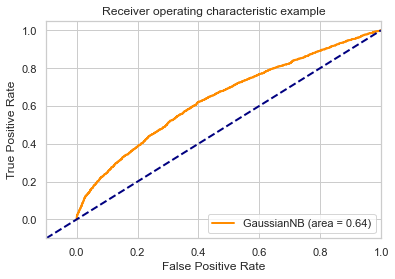

In [82]:
plt.figure()
lw = 2
plt.plot(
    fprs,
    tprs,
    color="darkorange",
    lw=lw,
    label="GaussianNB (area = %0.2f)" % roc_auc,
)
plt.plot([-0.1, 1], [-0.1, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [83]:
lr.coef_

array([[ 0.00986156,  0.00117864, -0.01294952,  0.40955734,  0.14395189,
         0.02423558,  0.04144773,  0.01642613,  0.01272955, -0.89026524]])

In [84]:
len(lr.coef_[0])

10

In [86]:
races_featurized_trunc_no_weather = races_featurized_trunc.drop(columns=[
    'temp',
    'msl',
    'rhum',
    'rain'
])
races_featurized_trunc_no_weather.head()

,metric,ncond,class,runners,margin,entropy of odds
0,3821.0,1,0,6,1.219263,1.350363
1,5229.0,5,0,9,1.218049,1.995151
2,3620.0,5,0,8,1.277320,1.786421
3,6637.0,1,0,10,1.286595,1.611062
4,1005.0,4,0,5,1.217043,1.254374


In [87]:
list(races_featurized_trunc_no_weather.columns)

['metric', 'ncond', 'class', 'runners', 'margin', 'entropy of odds']

In [88]:
races_featurized_scaled_no_weather = StandardScaler().fit_transform(races_featurized_trunc_no_weather)
races_featurized_scaled_no_weather

array([[ 2.12023367, -0.78087915, -0.02334147, -1.33021613, -0.28407401,
        -1.51101683],
       [ 3.7943978 ,  0.28921597, -0.02334147, -0.3361708 , -0.29627309,
         0.13454644],
       [ 1.88123723,  0.28921597, -0.02334147, -0.66751924,  0.29909296,
        -0.39815327],
       ...,
       [ 2.35923012,  0.28921597, -0.02334147,  0.65787453,  2.30887701,
         1.0446593 ],
       [ 1.40324435,  1.89435866, -0.02334147, -0.00482236,  0.49386836,
         0.15185863],
       [ 1.40324435,  1.89435866, -0.02334147,  0.65787453,  1.56385905,
         1.1826101 ]])

In [89]:
X_train, X_test, y_train, y_test = train_test_split(races_featurized_scaled_no_weather, target, test_size=0.3, random_state=42)

In [90]:
lr = LogisticRegression(random_state=0, max_iter=1000)
probs = lr.fit(X_train, y_train).predict_proba(X_test)

In [91]:
metrics.confusion_matrix(y_test, lr.fit(X_train, y_train).predict(X_test))

array([[3467,  394],
       [1646,  554]])

In [92]:
lr.score(X_train, y_train)

0.6536775106082037

In [93]:
lr.score(X_test, y_test)

0.6634218775779575

In [94]:
lr.coef_

array([[ 0.00883497, -0.00300179, -0.01343846,  0.40358828,  0.1448246 ,
        -0.88778653]])

In [95]:
len(lr.coef_[0])

6

## Random Forrests

In [165]:
from sklearn.ensemble import RandomForestClassifier

In [166]:
races_featurized_scaled.shape

(20201, 10)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(races_featurized_scaled, target, test_size=0.3, random_state=42)

In [168]:
rfc = RandomForestClassifier(max_depth = 12, criterion='entropy', n_estimators=100, random_state=42)
probs = rfc.fit(X_train, y_train).predict_proba(X_test)

In [169]:
rfc.n_features_in_

10

In [170]:
metrics.confusion_matrix(y_test, rfc.fit(X_train, y_train).predict(X_test))

array([[3519,  342],
       [1699,  501]])

In [171]:
rfc.score(X_train, y_train)

0.7616690240452617

In [172]:
rfc.score(X_test, y_test)

0.6632568883022604

In [173]:
probs_pos = [prob[1] for prob in probs]

In [174]:
fprs, tprs, thresholds = metrics.roc_curve(y_test, probs_pos, pos_label=1)
roc_auc = metrics.auc(fprs, tprs)

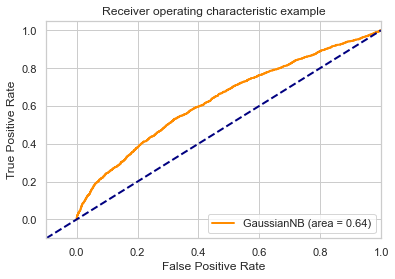

In [175]:
plt.figure()
lw = 2
plt.plot(
    fprs,
    tprs,
    color="darkorange",
    lw=lw,
    label="GaussianNB (area = %0.2f)" % roc_auc,
)
plt.plot([-0.1, 1], [-0.1, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [176]:
rfc.feature_importances_

array([7.36075997e-02, 4.90885281e-02, 1.01053906e-04, 6.39324053e-02,
       1.55611030e-01, 1.24419230e-01, 1.27898558e-01, 3.39844418e-02,
       1.01809072e-01, 2.69548081e-01])

In [177]:
X_train, X_test, y_train, y_test = train_test_split(races_featurized_scaled_no_weather, target, test_size=0.3, random_state=42)

In [178]:
rfc = RandomForestClassifier(max_depth = 12, criterion='entropy', n_estimators=100, random_state=42)
probs = rfc.fit(X_train, y_train).predict_proba(X_test)

In [179]:
rfc.n_features_in_

6

In [180]:
metrics.confusion_matrix(y_test, rfc.fit(X_train, y_train).predict(X_test))

array([[3469,  392],
       [1665,  535]])

In [181]:
rfc.score(X_train, y_train)

0.7610325318246111

In [182]:
rfc.score(X_test, y_test)

0.6606170598911071

In [183]:
rfc.feature_importances_

array([0.1311402 , 0.09457128, 0.00060491, 0.09068603, 0.28285666,
       0.40014093])